In [30]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from collections import Counter
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [21]:
# Function to load the MSTAR dataset and resize to 128 * 128
def get_MSTAR(train_dir, val_dir, test_dir):
    def load_images_from_folder(folder):
        images = []
        labels = []
        for label in os.listdir(folder):
            label_folder = os.path.join(folder, label)
            if os.path.isdir(label_folder):
                for filename in os.listdir(label_folder):
                    img_path = os.path.join(label_folder, filename)
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    if img is not None:
                        # Resize image to 128x128
                        img_resized = cv2.resize(img, (100, 100))
                        images.append(img_resized)
                        labels.append(label)
        return np.array(images), np.array(labels)

    X_train, y_train = load_images_from_folder(train_dir)
    X_val, y_val = load_images_from_folder(val_dir)
    X_test, y_test = load_images_from_folder(test_dir)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

# Function to display trained, validated, and tested sets
def display_class_counts(y_train, y_val, y_test):
    train_counts = Counter(y_train)
    val_counts = Counter(y_val)
    test_counts = Counter(y_test)
    classes = sorted(set(train_counts.keys()).union(set(val_counts.keys()).union(set(test_counts.keys()))))
    print(f"{'Class':<10} {'Train Count':<12} {'Val Count':<12} {'Test Count':<10}")
    print("="*44)
    for cls in classes:
        train_count = train_counts.get(cls, 0)
        val_count = val_counts.get(cls, 0)
        test_count = test_counts.get(cls, 0)
        print(f"{cls:<10} {train_count:<12} {val_count:<12} {test_count:<10}")

# Path to the training, validation, and testing datasets
train_dir = '/home/nathan/Documents/EEE4022S/New/DATASET/TRAIN'
val_dir = '/home/nathan/Documents/EEE4022S/New/DATASET/VAL'
test_dir = '/home/nathan/Documents/EEE4022S/New/DATASET/TEST'

In [22]:

# Dataset loading
X_train, y_train, X_val, y_val, X_test, y_test = get_MSTAR(train_dir, val_dir, test_dir)
display_class_counts(y_train, y_val, y_test)

Class      Train Count  Val Count    Test Count
2S1        230          80           141       
BRDM_2     230          80           141       
BTR_60     230          80           141       
D7         230          80           141       
SLICY      230          80           141       
T62        230          80           141       
ZIL131     230          80           141       
ZSU_23_4   230          80           141       


In [23]:

# Normalize the image data
X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Reshape the input data for CNN
X_train = X_train.reshape(X_train.shape[0], 100, 100, 1)
X_val = X_val.reshape(X_val.shape[0], 100, 100, 1)
X_test = X_test.reshape(X_test.shape[0], 100, 100, 1)

In [24]:
# Encode the labels
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_val_encoded = le.transform(y_val)
y_test_encoded = le.transform(y_test)

# Convert to categorical
num_classes = len(le.classes_)
y_train_cat = to_categorical(y_train_encoded, num_classes)
y_val_cat = to_categorical(y_val_encoded, num_classes)
y_test_cat = to_categorical(y_test_encoded, num_classes)


In [25]:
def create_cnn_model(input_shape=(128, 128, 1), num_classes=8):
    model = Sequential([
        Conv2D(20, kernel_size=(5, 5), strides=(5, 5), activation='relu', input_shape=input_shape),
        Flatten(),
        Dense(num_classes, activation='softmax')  # Add a Dense layer for classification
    ])
    return model

In [26]:
# Compile the model
num_classes = len(le.classes_)  # Ensure this matches the number of unique classes
model = create_cnn_model(input_shape=(100, 100, 1), num_classes=num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train_cat, epochs=10, batch_size=32, validation_data=(X_val, y_val_cat))


Epoch 1/10


/home/nathan/anaconda3/envs/MLenv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.1750 - loss: 1.9779 - val_accuracy: 0.4031 - val_loss: 1.4491
Epoch 2/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6205 - loss: 1.1375 - val_accuracy: 0.8406 - val_loss: 0.7066
Epoch 3/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8692 - loss: 0.6009 - val_accuracy: 0.9625 - val_loss: 0.3693
Epoch 4/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9313 - loss: 0.3398 - val_accuracy: 0.9594 - val_loss: 0.2813
Epoch 5/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9772 - loss: 0.1943 - val_accuracy: 0.9438 - val_loss: 0.2353
Epoch 6/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9748 - loss: 0.1470 - val_accuracy: 0.7719 - val_loss: 0.6619
Epoch 7/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9470 - loss: 0.2070 - val_accuracy: 0.9766 - val_loss: 0.1435
Epoch 8/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9936 - loss: 0.0733 - val_accuracy: 0.9625 - val_loss: 0.1444
Epo

In [27]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test_cat)
print(f"Test accuracy: {test_acc:.4f}")

# Generate predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_cat, axis=1)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=le.classes_))

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8957 - loss: 0.2983 
Test accuracy: 0.9566
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Classification Report:
              precision    recall  f1-score   support

         2S1       0.93      0.99      0.96       141
      BRDM_2       0.99      0.95      0.97       141
      BTR_60       0.99      0.99      0.99       141
          D7       0.99      0.99      0.99       141
       SLICY       1.00      1.00      1.00       141
         T62       1.00      0.74      0.85       141
      ZIL131       0.97      0.99      0.98       141
    ZSU_23_4       0.82      1.00      0.90       141

    accuracy                           0.96      1128
   macro avg       0.96      0.96      0.96      1128
weighted avg       0.96      0.96      0.96      1128



In [9]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 19)     │           323 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 19456)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │       155,656 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 467,939 (1.79 MB)

 Trainable params: 155,979 (609.29 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 311,960 (1.19 MB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


/home/nathan/anaconda3/envs/MLenv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


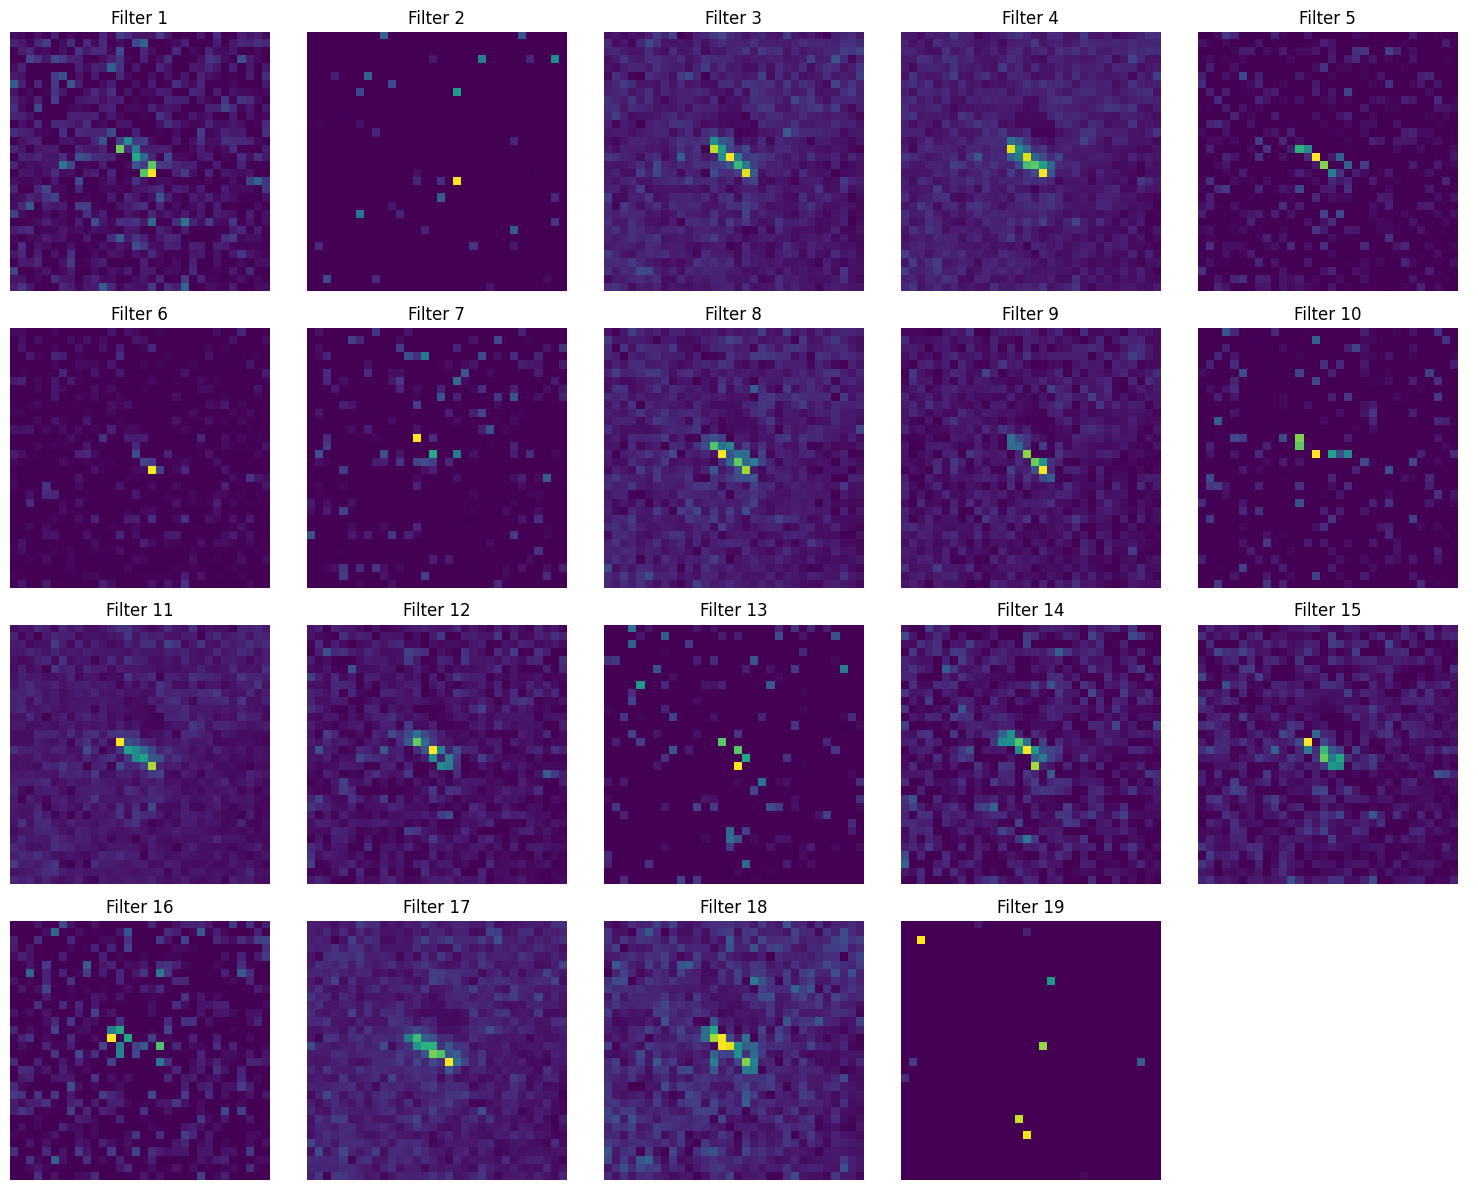

In [10]:
# Create the original model
original_model = create_cnn_model()

# Create a new model that outputs the Conv2D layer activations
conv_layer = original_model.layers[0]
feature_model = Model(inputs=original_model.inputs, outputs=conv_layer.output)

# Generate a random input image (you should use your actual input image here)
img_path = '/home/nathan/Documents/EEE4022S/New/DATASET/TRAIN/T62/HB19877.JPG'  # Replace with your image path
img = load_img(img_path, target_size=(128, 128), color_mode='grayscale')
input_image = img_to_array(img)
input_image = np.expand_dims(input_image, axis=0)  # Add batch dimension


# Get the feature maps
feature_maps = feature_model.predict(input_image)

# Plot the feature maps
fig, axes = plt.subplots(4, 5, figsize=(15, 12))
for i, ax in enumerate(axes.flat):
    if i < feature_maps.shape[3]:
        ax.imshow(feature_maps[0, :, :, i], cmap='viridis')
        ax.axis('off')
        ax.set_title(f'Filter {i+1}')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()

In [11]:
# Get the feature maps
feature_maps = feature_model.predict(input_image)

# Select the first feature map (you can change the index to select a different one)
selected_feature_map = feature_maps[0, :, :, 0]

# Normalize the feature map to 0-255 range
normalized_feature_map = ((selected_feature_map - selected_feature_map.min()) * (1/(selected_feature_map.max() - selected_feature_map.min()) * 255)).astype('uint8')

# Create a figure (without displaying it)
plt.figure(figsize=(5, 5))
plt.imshow(normalized_feature_map, cmap='viridis')
plt.axis('off')

# Save the figure as a JPG file
plt.savefig('conv_layer_output.jpg', bbox_inches='tight', pad_inches=0)
plt.close()  # Close the figure to free up memory

print("test.jpg'")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
test.jpg'


In [37]:
# Save the output as a NumPy array


print(f"Conv2D layer output shape: {feature_maps.shape}")
print("Output saved as 'last_conv_layer_output.npy'")

Conv2D layer output shape: (1, 32, 32, 19)
Output saved as 'last_conv_layer_output.npy'


In [17]:
# Assuming your model is called 'model'
conv_layer = model.layers[0]  # The Conv2D layer is the first layer (index 0)
weights = conv_layer.get_weights()

In [36]:

def create_cnn_model_with_features(input_shape=(100, 100, 1), num_classes=8):
    inputs = Input(shape=input_shape)
    
    # First convolutional layer
    conv1 = Conv2D(20, kernel_size=(5, 5), strides=(5, 5), activation='relu')(inputs)
    
    # Flatten layer
    flatten = Flatten()(conv1)
    
    # Output layer
    outputs = Dense(num_classes, activation='softmax')(flatten)
    
    # Create the full model
    full_model = Model(inputs=inputs, outputs=outputs)
    
    # Create a model that outputs both the final prediction and the feature maps
    feature_model = Model(inputs=inputs, outputs=[conv1, outputs])
    
    return full_model, feature_model


In [37]:
# Create both models
full_model, feature_model = create_cnn_model_with_features(input_shape=(100, 100, 1), num_classes=num_classes)

# Compile the full model
full_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = full_model.fit(X_train, y_train_cat, epochs=10, batch_size=32, validation_data=(X_val, y_val_cat))

# Function to extract feature maps and assign them to arrays
def extract_feature_maps(model, input_data):
    feature_maps, _ = model.predict(input_data)
    
    feature_map_arrays = []
    for i in range(feature_maps.shape[-1]):
        feature_map = feature_maps[:, :, :, i]
        feature_map_arrays.append(feature_map)
    
    return feature_map_arrays

# Extract feature maps for training data
train_feature_maps = extract_feature_maps(feature_model, X_train)

# Extract feature maps for validation data
val_feature_maps = extract_feature_maps(feature_model, X_val)

# Extract feature maps for test data
test_feature_maps = extract_feature_maps(feature_model, X_test)

# Assign feature maps to named arrays
for i, feature_map in enumerate(train_feature_maps):
    globals()[f'feature_map_train_{i+1}'] = feature_map

for i, feature_map in enumerate(val_feature_maps):
    globals()[f'feature_map_val_{i+1}'] = feature_map

for i, feature_map in enumerate(test_feature_maps):
    globals()[f'feature_map_test_{i+1}'] = feature_map

print("Feature maps have been assigned to arrays.")

# Example of how to access a feature map
print(f"Shape of feature_map_train_1: {feature_map_train_1.shape}")
print(f"Shape of feature_map_val_1: {feature_map_val_1.shape}")
print(f"Shape of feature_map_test_1: {feature_map_test_1.shape}")

Epoch 1/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2574 - loss: 1.9042 - val_accuracy: 0.6531 - val_loss: 1.1975
Epoch 2/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6702 - loss: 1.0381 - val_accuracy: 0.7906 - val_loss: 0.6608
Epoch 3/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8415 - loss: 0.5702 - val_accuracy: 0.9328 - val_loss: 0.3628
Epoch 4/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9211 - loss: 0.3140 - val_accuracy: 0.9578 - val_loss: 0.2529
Epoch 5/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9799 - loss: 0.1916 - val_accuracy: 0.9703 - val_loss: 0.1811
Epoch 6/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9839 - loss: 0.1524 - val_accuracy: 0.9875 - val_loss: 0.1466
Epoch 7/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9917 - loss: 0.0857 - val_accuracy: 0.9625 - val_loss: 0.1758
Epoch 8/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9924 - loss: 0.0816 - val_accuracy: 0.9719 - val_loss: